# Overvies of needed libraries and modules

- The main framework for working with graphs and predictions on them is [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/). It contains various methods for Deep Learning on graphs. 
- Torch is essential for Graph neural netowrks. We can use activation functions, normalization methods, 'Sequential' to stack layers from there.
- Sklearn can be used for metrics computing and for simple models applying (like PCA for plotting weights of models).
- Netoworkx and matplotlip will be used for data visualization.

In [1]:
# !pip install torch_geometric

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import accuracy_score
import random
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


# Dataset Loading

To check the Exploratory Data Analysis check our [colab]()


In [ ]:
dataset = Planetoid(root='./CiteseerData', name='Citeseer')
data = dataset[0]
print(f"Dataset: {dataset}, Number of nodes: {data.num_nodes}, Number of edges: {data.num_edges}")

dataset_cora = Planetoid(root='./CoraData', name='Cora')
data_cora = dataset_cora[0]


Dataset: Citeseer(), Number of nodes: 3327, Number of edges: 9104


# Models

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [11]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)


# Training and Evaluation

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels = data.y.cpu().numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)



def train(model, data, optimizer, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [13]:
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    logits = model(data)
    pred = logits.argmax(dim=1)
    acc_train = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    acc_val = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
    acc_test = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    return acc_train, acc_val, acc_test


# Pipeline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

gcn = GCN(input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

print("Training GCN...")
train(gcn, data, optimizer)
gcn_acc = evaluate(gcn, data)
print(f"GCN Accuracy - Train: {gcn_acc[0]:.4f}, Val: {gcn_acc[1]:.4f}, Test: {gcn_acc[2]:.4f}")


gat = GAT(input_dim=dataset.num_features, hidden_dim=8, output_dim=dataset.num_classes, heads=8).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)

print("Training GAT...")
train(gat, data, optimizer)
gat_acc = evaluate(gat, data)
print(f"GAT Accuracy - Train: {gat_acc[0]:.4f}, Val: {gat_acc[1]:.4f}, Test: {gat_acc[2]:.4f}")

# Comparison
if gat_acc[2] > gcn_acc[2]:
    print("GAT outperformed GCN.")
else:
    print("GCN outperformed GAT.")


Training GCN...
Epoch 0, Loss: 1.7922
Epoch 20, Loss: 0.1376
Epoch 40, Loss: 0.0513
Epoch 60, Loss: 0.0377
Epoch 80, Loss: 0.0325
Epoch 100, Loss: 0.0252
Epoch 120, Loss: 0.0464
Epoch 140, Loss: 0.0226
Epoch 160, Loss: 0.0274
Epoch 180, Loss: 0.0229
GCN Accuracy - Train: 1.0000, Val: 0.6800, Test: 0.6660
Training GAT...
Epoch 0, Loss: 1.8148
Epoch 20, Loss: 0.0054
Epoch 40, Loss: 0.0032
Epoch 60, Loss: 0.0064
Epoch 80, Loss: 0.0092
Epoch 100, Loss: 0.0056
Epoch 120, Loss: 0.0070
Epoch 140, Loss: 0.0063
Epoch 160, Loss: 0.0060
Epoch 180, Loss: 0.0050
GAT Accuracy - Train: 1.0000, Val: 0.6760, Test: 0.6880
GAT outperformed GCN.


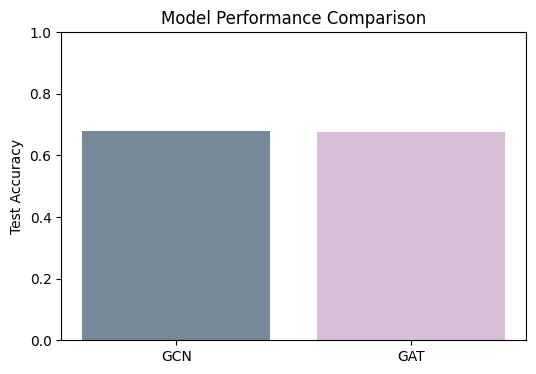

In [15]:
# Performance Comparison
import matplotlib.pyplot as plt

# Compare GCN and GAT accuracy
plt.figure(figsize=(6, 4))
plt.bar(["GCN", "GAT"], [gcn_acc[1], gat_acc[1]], color=['lightslategray', 'thistle'])
plt.ylabel("Test Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.show()


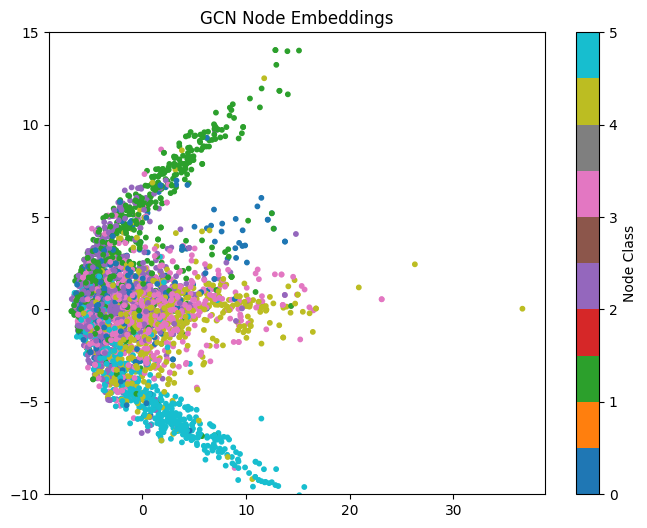

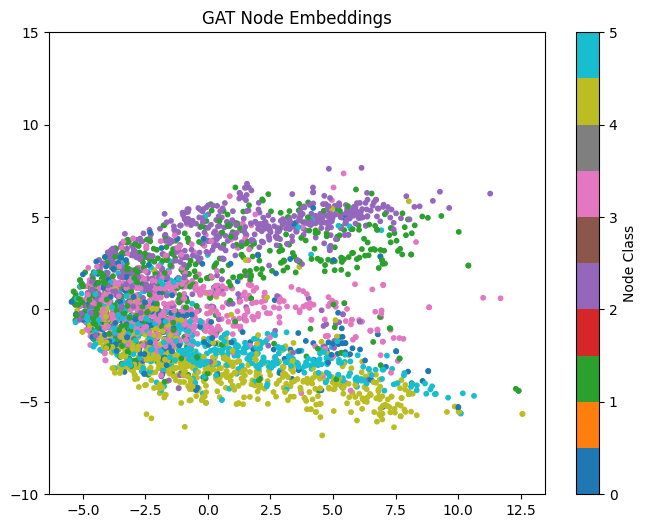

In [21]:
from sklearn.decomposition import PCA

def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        embeddings = logits.cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="tab10", s=10)
    plt.colorbar(scatter, label="Node Class")
    plt.title(title)
    plt.ylim(-10, 15)
    plt.show()

visualize_embeddings(gcn, data, "GCN Node Embeddings")
visualize_embeddings(gat, data, "GAT Node Embeddings")


Epoch 0, Loss: 1.7927
Epoch 20, Loss: 0.0730
Epoch 40, Loss: 0.0321
Epoch 60, Loss: 0.0699
Epoch 80, Loss: 0.0387
Epoch 100, Loss: 0.0369
Epoch 120, Loss: 0.0366
Epoch 140, Loss: 0.0448
Epoch 160, Loss: 0.0278
Epoch 180, Loss: 0.0487
Epoch 0, Loss: 1.8110
Epoch 20, Loss: 0.0015
Epoch 40, Loss: 0.0038
Epoch 60, Loss: 0.0048
Epoch 80, Loss: 0.0060
Epoch 100, Loss: 0.0058
Epoch 120, Loss: 0.0048
Epoch 140, Loss: 0.0044
Epoch 160, Loss: 0.0050
Epoch 180, Loss: 0.0053


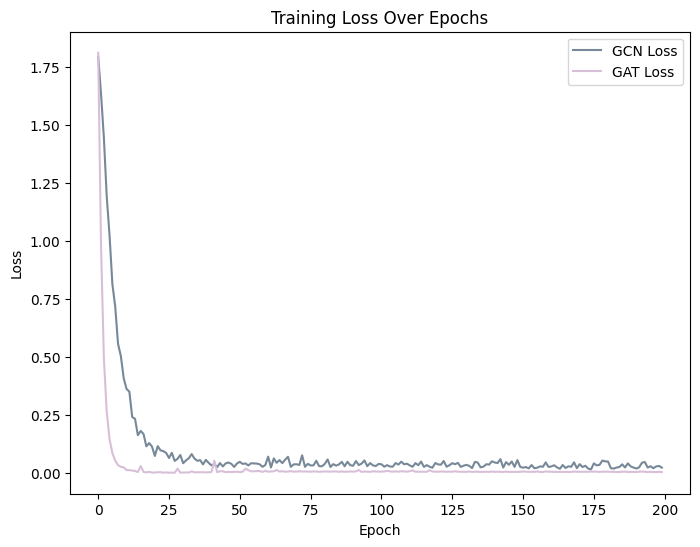

In [17]:
def train_with_loss_tracking(model, data, optimizer, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

gcn = GCN(data.num_features, 16, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
gcn_losses = train_with_loss_tracking(gcn, data, optimizer)

gat = GAT(data.num_features, 8, dataset.num_classes, heads=8).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)
gat_losses = train_with_loss_tracking(gat, data, optimizer)

plt.figure(figsize=(8, 6))
plt.plot(gcn_losses, label="GCN Loss", color="lightslategray")
plt.plot(gat_losses, label="GAT Loss", color="thistle")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


## Cora 

In [37]:
import os
from sklearn.decomposition import PCA
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Ensure the plots/ directory exists
os.makedirs("new_plots", exist_ok=True)

def train_with_loss_tracking(model, data, optimizer, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

def visualize_embeddings(model, data, title, filename):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        embeddings = logits.cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="tab10", s=10)
    plt.colorbar(scatter, label="Node Class")
    plt.title(title)
    plt.ylim(-10, 15)
    plt.savefig(f"plots/{filename}")
    plt.close()

def visualize_graph(data, title, filename, color_map):
    G = to_networkx(data, to_undirected=True)
    node_colors = [color_map[label] for label in data.y.cpu().numpy()]

    plt.figure(figsize=(10, 10))
    nx.draw(G, node_color=node_colors, node_size=10)
    plt.title(title)
    plt.savefig(f"plots/{filename}")
    plt.close()

def plot_losses(gcn_losses, gat_losses, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.plot(gcn_losses, label="GCN Loss", color="lightslategray")
    plt.plot(gat_losses, label="GAT Loss", color="thistle")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{dataset_name} Training Loss Over Epochs")
    plt.legend()
    plt.savefig(f"plots/{dataset_name}_losses.png")
    plt.close()

def plot_model_comparison(gcn_acc, gat_acc, dataset_name):
    plt.figure(figsize=(6, 4))
    plt.bar(["GCN", "GAT"], [gcn_acc[1], gat_acc[1]], color=['lightslategray', 'thistle'])
    plt.ylabel("Validation Accuracy")
    plt.title(f"{dataset_name} Model Performance Comparison")
    plt.ylim(0, 1)
    plt.savefig(f"plots/{dataset_name}_comparison.png")
    plt.close()

# Process both datasets
datasets = {"Citeseer": dataset, "Cora": data_cora}  # Assuming data_cora and dataset are preloaded Planetoid objects
color_map = ["paleturquoise", "lightslategray", "thistle", "mediumpurple", "lavenderblush", "tan"]

for dataset_name, dataset in datasets.items():
    # Handle dataset access based on its type
    if isinstance(dataset, torch_geometric.data.Dataset):
        data = dataset[0].to(device)  # Planetoid datasets are iterable
    else:
        data = dataset.to(device)  # If dataset is already a data object

    # Train GCN
    gcn = GCN(input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    print(f"Training GCN on {dataset_name}...")
    gcn_losses = train_with_loss_tracking(gcn, data, optimizer)
    gcn_acc = evaluate(gcn, data)

    # Train GAT
    gat = GAT(input_dim=dataset.num_features, hidden_dim=8, output_dim=dataset.num_classes, heads=8).to(device)
    optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)
    print(f"Training GAT on {dataset_name}...")
    gat_losses = train_with_loss_tracking(gat, data, optimizer)
    gat_acc = evaluate(gat, data)

    # Visualize Results
    plot_losses(gcn_losses, gat_losses, dataset_name)
    plot_model_comparison(gcn_acc, gat_acc, dataset_name)
    visualize_embeddings(gcn, data, f"{dataset_name} GCN Node Embeddings", f"{dataset_name}_gcn_embeddings.png")
    visualize_embeddings(gat, data, f"{dataset_name} GAT Node Embeddings", f"{dataset_name}_gat_embeddings.png")
    visualize_graph(data, f"{dataset_name} Network with Node Classes", f"{dataset_name}_graph.png", color_map)

print("All plots saved in the 'plots/' folder.")


AttributeError: 'GlobalStorage' object has no attribute 'num_classes'

# Boosting

In [ ]:
# class BoostedGNN:
#     def __init__(self, base_model_class, input_dim, hidden_dim, output_dim, n_estimators, data, lr=0.01):
#         self.models = []
#         self.alphas = []
#         self.data = data
#         self.n_estimators = n_estimators
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#         # Initialize models and optimizers
#         for _ in range(n_estimators):
#             model = base_model_class(input_dim, hidden_dim, output_dim).to(self.device)
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
#             self.models.append((model, optimizer))

#     def train(self):
#         # Initialize weights for each node
#         weights = torch.ones(self.data.num_nodes, dtype=torch.float, device=self.device)

#         for i, (model, optimizer) in enumerate(self.models):
#             print(f"Training Model {i + 1}...")
#             train_boosted_model(model, self.data, weights, optimizer)

#             # Evaluate model and calculate alpha
#             model.eval()
#             out = model(self.data)
#             pred = out.argmax(dim=1)
#             incorrect = (pred[self.data.train_mask] != self.data.y[self.data.train_mask])
#             err = torch.sum(weights[self.data.train_mask] * incorrect.float()) / torch.sum(weights[self.data.train_mask])
            
#             # Compute model weight (alpha)
#             alpha = 0.5 * torch.log((1 - err) / (err + 1e-10))
#             self.alphas.append(alpha.item())

#             # Update node weights
#             weights[self.data.train_mask] *= torch.exp(alpha * incorrect.float())
#             weights[self.data.train_mask] /= torch.sum(weights[self.data.train_mask])

#     @torch.no_grad()
#     def predict(self):
#         final_scores = torch.zeros((self.data.num_nodes, 7), device=self.device)
#         for model, alpha in zip(self.models, self.alphas):
#             logits = model[0](self.data)
#             final_scores += alpha * logits
#         return final_scores.argmax(dim=1)
    

In [ ]:
# def train_boosted_model(model, data, weights, optimizer, epochs=50):
#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         out = model(data)
        
#         # Compute weighted loss manually
#         log_probs = out[data.train_mask]
#         targets = data.y[data.train_mask]
#         loss = -torch.sum(weights[data.train_mask] * log_probs[torch.arange(len(targets)), targets]) / torch.sum(weights[data.train_mask])
        
#         loss.backward()
#         optimizer.step()


In [ ]:
# # Boosted GCN
# boosted_gcn = BoostedGNN(GCN, input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes, n_estimators=5, data=data)
# boosted_gcn.train()
# boosted_gcn_pred = boosted_gcn.predict()
# boosted_gcn_acc = accuracy_score(data.y[data.test_mask].cpu(), boosted_gcn_pred[data.test_mask].cpu())
# print(f"Boosted GCN Test Accuracy: {boosted_gcn_acc:.4f}")

# # Boosted GAT
# boosted_gat = BoostedGNN(GAT, input_dim=dataset.num_features, hidden_dim=8, output_dim=dataset.num_classes, n_estimators=5, data=data)
# boosted_gat.train()
# boosted_gat_pred = boosted_gat.predict()
# boosted_gat_acc = accuracy_score(data.y[data.test_mask].cpu(), boosted_gat_pred[data.test_mask].cpu())
# print(f"Boosted GAT Test Accuracy: {boosted_gat_acc:.4f}")
